## Training Functions

### Plot graph

In [1]:
import nnfs
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.pyplot as plt
from nnfs.datasets import spiral_data, vertical_data

nnfs.init()

def plot_prediction_performance(
    model: list | tuple,
    X, y,
    num_points: int = 100,
    device: str = 'cpu'
) -> None:
    """Plots the performance of the model in the spiral dataset with 3 categories"""
    def probabilities_to_rgb(probabilities_array):
        """ Maps an array of probabilities to RGB colors."""
        # Ensure that probabilities sum up to 1 for all data points
        if not torch.all(torch.isclose(torch.sum(probabilities_array, dim=1), torch.tensor(1.0).to(device))):
            raise ValueError("Probabilities must sum up to 1 for all data points.")
        
        # Map probabilities to RGB channels (0-255) for all data points
        r, g, b = (probabilities_array * 255).to(torch.int32).T
        
        # Return the RGB colors as a torch tensor
        return torch.stack((r, g, b), dim=1)

    # Create a meshgrid of points in the (-1,1)x(-1,1) space
    x_val = torch.linspace(-1, 1, num_points)
    y_val = torch.linspace(-1, 1, num_points)
    x_grid, y_grid = torch.meshgrid(x_val, y_val, indexing='xy')
    
    # Flatten the grids into 1D arrays
    x_flat = x_grid.flatten()
    y_flat = y_grid.flatten()
    
    # Combine the flattened arrays into an Nx2 array
    XX_tuples = torch.stack((x_flat, y_flat), dim=1).to(device)
    
    # Perform a forward pass through the network
    with torch.no_grad():
        model.eval()
        logits = model(XX_tuples)
        probabilities = torch.softmax(logits, dim=1)
    
    rgb_colors = probabilities_to_rgb(probabilities)
    probs_2d = rgb_colors.reshape(num_points, num_points, 3)
    
    # Assumed 3 categories - change this if different
    colors = ['r' if label == 0 else 'g' if label == 1 else 'b' for label in y]
    
    plt.imshow(probs_2d.cpu().numpy(), extent=(-1, 1, -1, 1), interpolation='bilinear')
    plt.scatter(X[:, 0].cpu(), -X[:, 1].cpu(), c=colors)
    plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

def plot_evolution(w_C, w_A, window_size=20):
    # smooth the data with a moving average
    w_C = np.convolve(w_C, np.ones(window_size), 'valid') / window_size
    w_A = np.convolve(w_A, np.ones(window_size), 'valid') / window_size
    
    time = np.linspace(0, 1, len(w_A))

    # Create segments for the line
    points = np.array([w_A, w_C]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a line collection
    norm = Normalize(vmin=time.min(), vmax=time.max())  # Normalize time values
    lc = LineCollection(segments, cmap="viridis", norm=norm)
    lc.set_array(time)  # Use time to color the line

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.add_collection(lc)
    ax.autoscale()  # Adjust axis limits
    ax.set_xlabel("W_A")
    ax.set_ylabel("W_C")
    ax.set_title("Final result: {:.3f}".format(w_C[-1]))
    ax.grid(True)

    # Add a colorbar to show time progression
    cbar = plt.colorbar(lc, ax=ax)
    cbar.set_label("Time")

    # plot initial and final points
    plt.scatter(w_A[0], w_C[0], c='r', label='Initial')
    plt.scatter(w_A[-1], w_C[-1], c='g', label='Final')

    plt.show()

## SHD

In [3]:
def get_As_and_Cs(model):
    Cs, As = [], []
    for param in model.parameters():
        analog_tile = param.analog_tile
        # Access the TransferCompound device
        device_weights = analog_tile.get_hidden_parameters()
        A = device_weights['hidden_weights_0']
        C = device_weights['hidden_weights_1']
        As.append(A)
        Cs.append(C)
    return torch.stack(Cs), torch.stack(As)

In [4]:
import torch
import torch.nn as nn
from aihwkit.nn import AnalogLinear
from aihwkit.simulator.presets import TikiTakaEcRamPreset
from aihwkit.optim import AnalogSGD

rpu_config = TikiTakaEcRamPreset()
rpu_config.device.random_selection = False
rpu_config.device.scale_transfer_lr = True
rpu_config.device.transfer_lr = 1
rpu_config.device.fast_lr = 0.002
rpu_config.device.transfer_columns = True
rpu_config.device.transfer_every = 10
#rpu_config.update.desired_bl = 100
rpu_config.mapping.digital_bias = False
#rpu_config.device.transfer_update.desired_bl = 1
rpu_config.device.unit_cell_devices[0].gamma_up = 0.01153
rpu_config.device.unit_cell_devices[0].gamma_down = 0.05085


# Define two parallel networks
class Network(nn.Module):
    def __init__(self, device='cpu'):
        super(Network, self).__init__()
        self.l1 = AnalogLinear(1, 1, bias=False, rpu_config=rpu_config).to(device)

    def forward(self, x):
        x = self.l1(x)
        return x

model = Network()
   
for param in model.parameters():
    analog_tile = param.analog_tile
    # Access the TransferCompound device
    device_weights = analog_tile.get_hidden_parameters()
    for key, value in device_weights.items():
        print(f"{key}: {value}")

max_bound_0: tensor([[1.1801]])
min_bound_0: tensor([[-0.8121]])
dwmin_up_0: tensor([[0.0021]])
dwmin_down_0: tensor([[0.0022]])
decay_scales_0: tensor([[1.]])
diffusion_rates_0: tensor([[0.]])
reset_bias_0: tensor([[0.]])
drift_nu_0: tensor([[0.]])
slope_up_0: tensor([[-5.7121e-05]])
slope_down_0: tensor([[0.0002]])
hidden_weights_0: tensor([[0.]])
max_bound_1: tensor([[1.1940]])
min_bound_1: tensor([[-0.8299]])
dwmin_up_1: tensor([[0.0014]])
dwmin_down_1: tensor([[0.0014]])
decay_scales_1: tensor([[1.]])
diffusion_rates_1: tensor([[0.]])
reset_bias_1: tensor([[0.]])
drift_nu_1: tensor([[0.]])
slope_up_1: tensor([[-0.0001]])
slope_down_1: tensor([[0.0009]])
hidden_weights_1: tensor([[0.8043]])


In [5]:
for param in model.parameters():
    analog_tile = param.analog_tile
    print(analog_tile.rpu_config.update.desired_bl)

31


In [6]:
for param in model.parameters():
    analog_tile = param.analog_tile
    print(analog_tile.rpu_config.device.transfer_update.desired_bl)

31


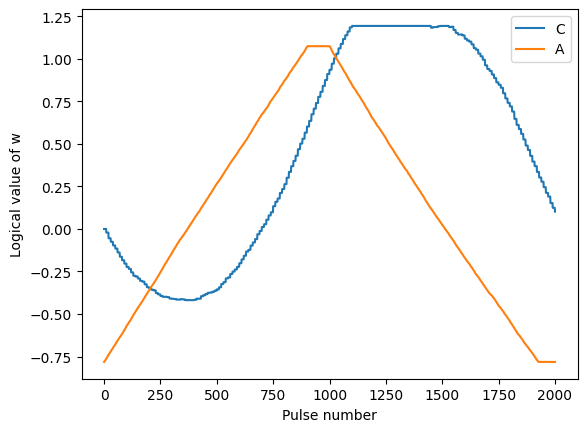

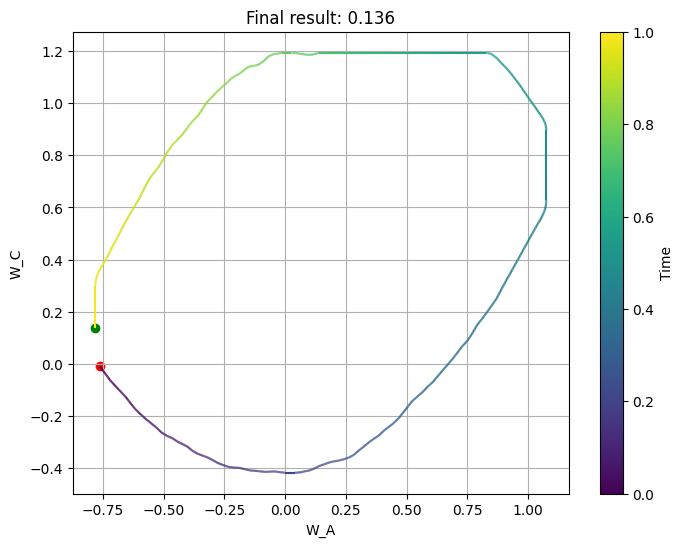

In [7]:
model = Network()

optimizer = AnalogSGD(model.parameters(), lr=0.035)
# lr from optimizer is the lr of the C matrix, only if scale_transfer_lr is True,
# lr of C = lr * transfer_lr
# else it does nothing and the lr of the C matrix is the one defined by transfer_lr
# the only way to control lr of A is through fast_lr


params = model.l1.analog_module.get_hidden_parameters()
params['hidden_weights_0'] = params['min_bound_0']
params['hidden_weights_1'] = torch.tensor([[0]])
model.l1.analog_module.set_hidden_parameters(params)

w_C = [params['hidden_weights_1'].item()]
w_A = [params['hidden_weights_0'].item()]

for i in range(2000):
    if i < 1000:
        y = model(torch.tensor([[1.0]]))
        l = (1 - y)
    else:
        y = model(torch.tensor([[1.0]]))
        l = y

    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    params = model.l1.analog_module.get_hidden_parameters()
    w_C.append(params['hidden_weights_1'].item())
    w_A.append(params['hidden_weights_0'].item())

plt.plot(w_C, label='C')
plt.plot(w_A, label='A')
plt.xlabel('Pulse number')
plt.ylabel('Logical value of w')
plt.legend()
plot_evolution(w_C, w_A)

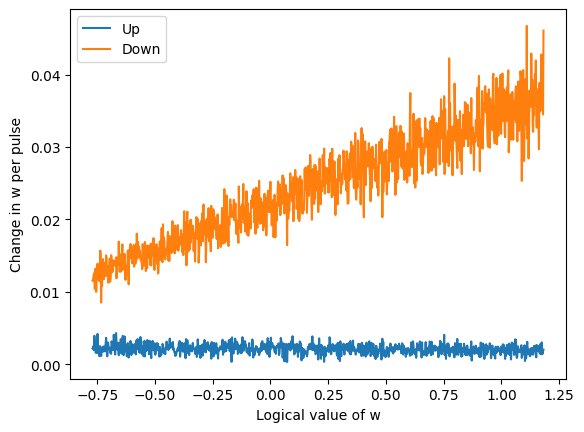

In [8]:
model = Network()

optimizer = AnalogSGD(model.parameters())


# for a seuqnece of points of values between -1 and 1 for conductance,
# get the resulting value for the update

params = model.l1.analog_module.get_hidden_parameters()
minb = params['min_bound_0'].item()
maxb = params['max_bound_0'].item()
conductance = torch.linspace(minb+0.04, maxb-0.04, 1000)
up_result = []
down_result = []

for c in conductance:
    params = model.l1.analog_module.get_hidden_parameters()
    params['hidden_weights_0'] = torch.tensor([[c]])
    model.l1.analog_module.set_hidden_parameters(params)
    out = model(torch.tensor([[10.0]]))
    out.backward()
    optimizer.step()
    optimizer.zero_grad()
    down_result.append(c - model.l1.analog_module.get_hidden_parameters()['hidden_weights_0'].item())

for c in conductance:
    params = model.l1.analog_module.get_hidden_parameters()
    params['hidden_weights_0'] = torch.tensor([[c]])
    model.l1.analog_module.set_hidden_parameters(params)                                  
    out = model(torch.tensor([[-1.0]]))
    out.backward()
    optimizer.step()
    optimizer.zero_grad()
    up_result.append(model.l1.analog_module.get_hidden_parameters()['hidden_weights_0'].item() - c)

plt.plot(conductance, up_result, label='Up')
plt.plot(conductance, down_result, label='Down')
plt.xlabel('Logical value of w')
plt.ylabel('Change in w per pulse')
plt.legend()
plt.show()

## Training

In [19]:
from IPython.display import clear_output

def training_run(X, y, model, optimizer, loss_fn, epochs, batch_size=1):
    loss = []
    accuracy = []
    # save in a list the historical values of a weight of dense2_C and the same neuron in dense2_A
    neuron = 0
    weight = 0

    params = model.l1.analog_module.get_hidden_parameters()
    w_C = [params['hidden_weights_1'][neuron][weight].item()]
    w_A = [params['hidden_weights_0'][neuron][weight].item()]
    
    for e in range(epochs):

        perm = torch.randperm(len(X))
        X = X[perm]
        y = y[perm]
        # batch the data
        X_batched = torch.split(X, batch_size)
        y_batched = torch.split(y, batch_size)

        epoch_loss = []
        epoch_accuracy = []
        for x, y_true in zip(X_batched, y_batched):
            output = model(x)
            l = loss_fn(output, y_true)
            epoch_loss.append(l.item())

            # accuracy if loss is crossentropy
            if isinstance(loss_fn, nn.CrossEntropyLoss):
                correct_predictions = torch.sum(torch.argmax(output, axis=1) == y_true)
                epoch_accuracy.append(correct_predictions.item() / len(y_true))

            # backward pass
            l.backward()

            # update params
            optimizer.step()
            optimizer.zero_grad()

            # save in a list the historical values of a weight of dense2_C and the same neuron in dense2_A
            params = model.l1.analog_module.get_hidden_parameters()
            w_C.append(params['hidden_weights_1'][neuron][weight].item())
            w_A.append(params['hidden_weights_0'][neuron][weight].item())


        loss.append(np.mean(epoch_loss))
        if epoch_accuracy != []:
            accuracy.append(np.mean(epoch_accuracy))
        if (e+1) % 200 == 0:
            clear_output(wait=True)
            plt.plot(loss)
            plt.title(f'Final Loss: {np.mean(loss[-20:]):.2f}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()
            if epoch_accuracy != []:
                plt.plot(accuracy)
                plt.title(f'Final Accuracy: {np.mean(accuracy[-20:]):.2f}')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.show()

        if np.isnan(loss[-1]):
            break

    return loss, accuracy, w_C, w_A


In [21]:
from IPython.display import clear_output

def training_run(X, y, model, optimizer, loss_fn, epochs, batch_size=1):
    loss = []
    accuracy = []
    # save in a list the historical values of a weight of dense2_C and the same neuron in dense2_A
    
    for e in range(epochs):
        perm = torch.randperm(len(X))
        X = X[perm]
        y = y[perm]
        # batch the data
        X_batched = torch.split(X, batch_size)
        y_batched = torch.split(y, batch_size)

        epoch_loss = []
        epoch_accuracy = []
        for x, y_true in zip(X_batched, y_batched):
            output = model(x)
            l = loss_fn(output, y_true)
            epoch_loss.append(l.item())

            # accuracy if loss is crossentropy
            if isinstance(loss_fn, nn.CrossEntropyLoss):
                correct_predictions = torch.sum(torch.argmax(output, axis=1) == y_true)
                epoch_accuracy.append(correct_predictions.item() / len(y_true))

            # backward pass
            l.backward()

            # update params
            optimizer.step()
            optimizer.zero_grad()



        loss.append(np.mean(epoch_loss))
        if epoch_accuracy != []:
            accuracy.append(np.mean(epoch_accuracy))
        if (e+1) % 200 == 0:
            clear_output(wait=True)
            plt.plot(loss)
            plt.title(f'Final Loss: {np.mean(loss[-20:]):.2f}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()
            if epoch_accuracy != []:
                plt.plot(accuracy)
                plt.title(f'Final Accuracy: {np.mean(accuracy[-20:]):.2f}')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.show()
                
        if np.isnan(loss[-1]):
            break

    model.eval()
    real_output = model(X)
    loss = loss_fn(real_output, y).item()
    if isinstance(loss_fn, nn.CrossEntropyLoss):
        correct_predictions = torch.sum(torch.argmax(real_output, axis=1) == y)
        accuracy = correct_predictions.item() / len(y)

    return loss, accuracy

### Spiral_data

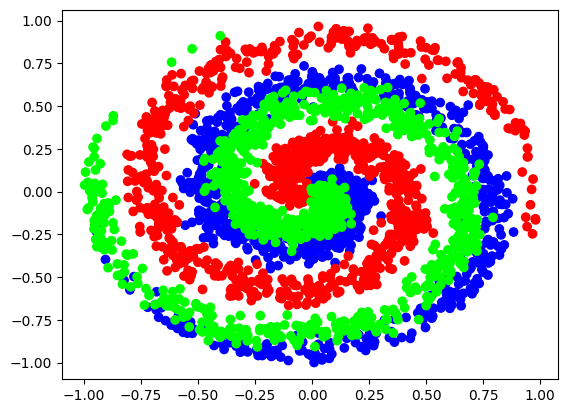

In [11]:
nnfs.init()
X_np, y_np = spiral_data(samples=1000, classes=3)

# plot spiral data
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='brg')

In [12]:
from aihwkit.simulator.configs import PrePostProcessingParameter, InputRangeParameter
from aihwkit.simulator.tiles.transfer_for_simple_TT import TorchTransferTile

class Analog_Network_spiral(nn.Module):
    
    def __init__(self, rpu_config=TikiTakaEcRamPreset(), t=[5, 1], device='cpu'):
        super(Analog_Network_spiral, self).__init__()
        # rpu_config.mapping.digital_bias = False
        # rpu_config.forward.out_scale = 5
        # rpu_config.mapping.weight_scaling_omega = 0.2
        # rpu_config.mapping.learn_out_scaling = True

        
        ## CHEATING
        # rpu_config.device.unit_cell_devices[0].dw_min = 0.0002
        # rpu_config.device.unit_cell_devices[1].dw_min = 0.0002
        # rpu_config.device.transfer_forward.is_perfect = True
        # rpu_config.forward.is_perfect = True
        # rpu_config.backward.is_perfect = True

        ## FURTHER TESTING
        # rpu_config.forward.inp_res = 1/510 # 9 bits
        # rpu_config.forward.max_bm_res = 1/512 # 9 bits
        # rpu_config.forward.out_noise = 0.1
        # rpu_config.device.transfer_forward.inp_res = 1/510 # 9 bits
        # rpu_config.pre_post = PrePostProcessingParameter(input_range=InputRangeParameter())

        ## DO NOT SEEM TO MATTER MUCH
        # rpu_config.update.desired_bl = 20000
        # rpu_config.device.transfer_update.desired_bl = 20000
        # rpu_config.device.unit_cell_devices[0].dw_min_std = 0.0
        # rpu_config.device.unit_cell_devices[1].dw_min_std = 0.0
        # rpu_config.device.unit_cell_devices[0].mult_noise = False
        # rpu_config.device.unit_cell_devices[1].mult_noise = False
        

        rpu_config.device.transfer_every = t[0]
        self.l1 = AnalogLinear(2, 64, bias=True, rpu_config=rpu_config).to(device)
        #self.l1 = TorchTransferTile(2, 64, bias=True, rpu_config=rpu_config).to(device)
        rpu_config.device.transfer_every = t[1]
        self.l2 = AnalogLinear(64, 3, bias=True, rpu_config=rpu_config).to(device)
        #self.l2 = TorchTransferTile(64, 3, bias=True, rpu_config=rpu_config).to(device)

        # initialize weights using xavier
        self.l1.set_weights(weight = torch.nn.init.xavier_normal_(self.l1.get_weights()[0]), bias = torch.zeros_like(self.l1.get_weights()[1]))
        self.l2.set_weights(weight = torch.nn.init.xavier_normal_(self.l2.get_weights()[0]), bias = torch.zeros_like(self.l2.get_weights()[1])) #torch.randn_like(self.l2.get_weights()[0]) * 0.05




        # initialize auxiliary weights to 0
        # params = model.l1.analog_module.get_hidden_parameters()
        # params['hidden_weights_0'] = torch.zeros_like(params['hidden_weights_0'])
        # model.l1.analog_module.set_hidden_parameters(params)
        # params = model.l2.analog_module.get_hidden_parameters()
        # params['hidden_weights_0'] = torch.zeros_like(params['hidden_weights_0'])
        # model.l2.analog_module.set_hidden_parameters(params)
        
    def forward(self, x):
        if self.training:
            x = torch.relu(self.l1(x))
            x = self.l2(x)
            return x * 25
        else:
            self.l1_n = nn.Linear(2, 64, bias=True).to(x.device)
            self.l1_n.weight.data = self.l1.get_weights()[0]
            self.l1_n.bias.data = self.l1.get_weights()[1]
            self.l2_n = nn.Linear(64, 3, bias=True).to(x.device)
            self.l2_n.weight.data = self.l2.get_weights()[0]
            self.l2_n.bias.data = self.l2.get_weights()[1]

            x = torch.relu(self.l1_n(x))
            x = self.l2_n(x)
            return x * 25

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = spiral_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

rpu = TikiTakaEcRamPreset()
rpu.device.fast_lr = 0.007
t = [20, 1]

model = Analog_Network_spiral(rpu_config=rpu, t=t).to(device)
1/model.l1.analog_module.rpu_config.device.transfer_forward.inp_res

126.0

In [14]:
input = torch.tensor([1.0, 1.0])
#input = X[5]
l1 =  model.l1.get_weights()[0] @ input + model.l1.get_weights()[1]
l2 = model.l2.get_weights()[0] @ torch.relu(l1) + model.l2.get_weights()[1]
print('Real output: ', l2*25)

results = []
for i in range(10000):
    results.append(model(input))

# mean and std of the results
print('Mean: ', torch.stack(results).mean(dim=0))
print('Std: ', torch.stack(results).std(dim=0))
print('Signal to noise ratio: ', torch.stack(results).mean(dim=0) / torch.stack(results).std(dim=0))

Real output:  tensor([ 3.9298, -4.5596, -3.4045])
Mean:  tensor([ 4.0589, -4.8281, -3.1577], grad_fn=<MeanBackward1>)
Std:  tensor([2.9565, 2.9681, 2.4914], grad_fn=<StdBackward0>)
Signal to noise ratio:  tensor([ 1.3729, -1.6267, -1.2674], grad_fn=<DivBackward0>)


#### Grid search

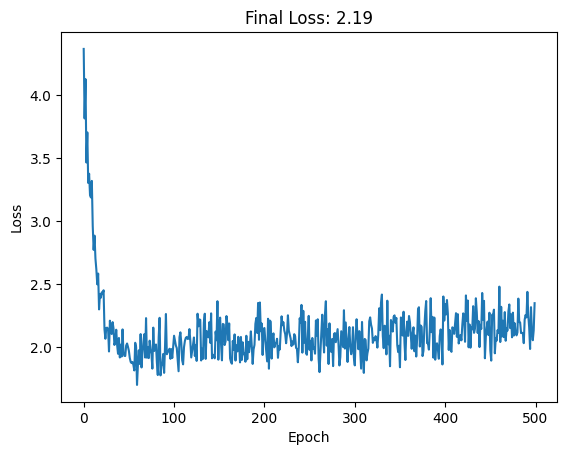

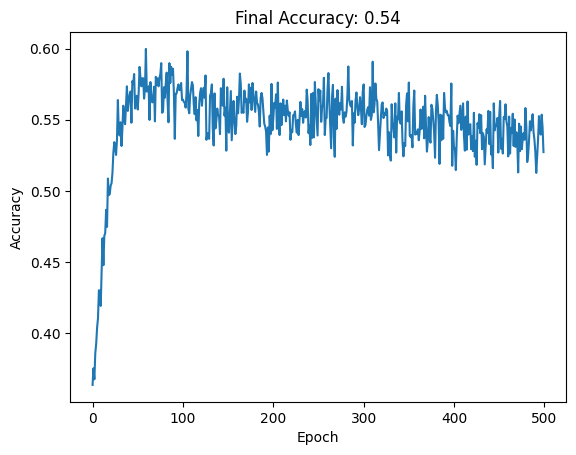

In [44]:
# grid search for hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
batch_size = 16
X_np, y_np = spiral_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

# grid search
learning_rate_C = [0.0064, 0.0128, 0.0256]
learning_rate_A = [0.0064, 0.0128, 0.0256]
t = [[1,1]]

best_loss = float('inf')
best_accuracy = 0
results = []

for lr_C in learning_rate_C:
    for lr_A in learning_rate_A:
            for t_ in t:
                l = []
                a = []
                for _ in range(2):
                    rpu = TikiTakaEcRamPreset()
                    rpu.device.fast_lr = lr_A
                    rpu.forward.out_noise = 0.04
                    model = Analog_Network_spiral(rpu_config=rpu, t=t_, device=device)
                    optimizer = AnalogSGD(model.parameters(), lr=lr_C)
                    # loss, accuracy, _, _ = training_run(X, y, model, optimizer, nn.CrossEntropyLoss(), 1000, batch_size=batch_size)
                    loss, accuracy = training_run(X, y, model, optimizer, nn.CrossEntropyLoss(), 1000, batch_size=batch_size)
                    l.append(loss)
                    a.append(accuracy)
                #print(f'Loss: {loss:.2f}, accuracy: {accuracy:.2f} for params: lr_C: {lr_C}, lr_A: {lr_A}, t: {t_}')
                results.append({
                    'lr_C': lr_C,
                    'lr_A': lr_A,
                    't': t_,
                    'loss': np.mean(l),
                    'accuracy': np.mean(a)
                })
                    # if loss < best_loss:
                    #     best_loss = loss
                    #     best_accuracy = accuracy
                    #     best_params = f'lr_C: {lr_C}, lr_A: {lr_A}, t: {t_}'

#print(f'Best loss: {best_loss}, best accuracy: {best_accuracy} for params: {best_params}')

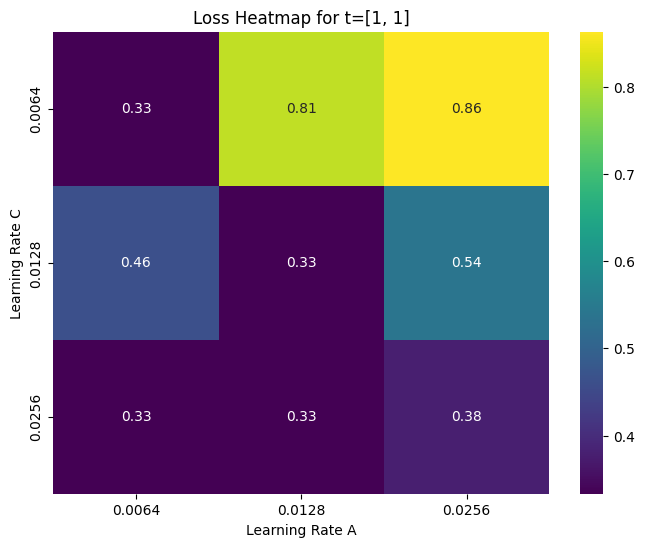

In [45]:
import pandas as pd

# Convert results to DataFrame
df = pd.DataFrame(results)

import seaborn as sns
import matplotlib.pyplot as plt

# Filter by specific `t_` if needed
t_fixed = [1, 1]  # Example
filtered_df = df[df['t'].apply(lambda x: x == t_fixed)]

# Pivot table for heatmap
heatmap_data = filtered_df.pivot(index="lr_C", columns="lr_A", values="accuracy")

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis")
plt.title(f"Loss Heatmap for t={t_fixed}")
plt.xlabel("Learning Rate A")
plt.ylabel("Learning Rate C")
plt.show()

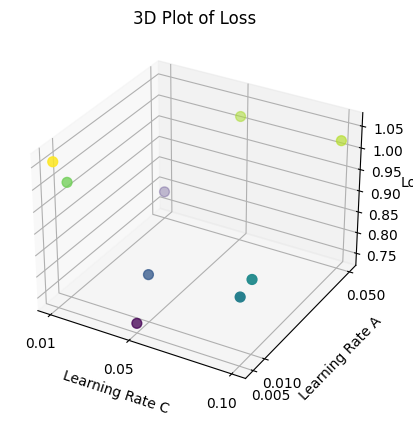

In [107]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Prepare data for 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract values
x = df['lr_C']
y = df['lr_A']
z = df['loss']

# Plot
ax.scatter(x, y, z, c=z, cmap='viridis', s=50)
ax.set_xlabel("Learning Rate C")
ax.set_ylabel("Learning Rate A")
ax.set_zlabel("Loss")
ax.set_xticks(learning_rate_C)
ax.set_yticks(learning_rate_A)
plt.title("3D Plot of Loss")
plt.show()

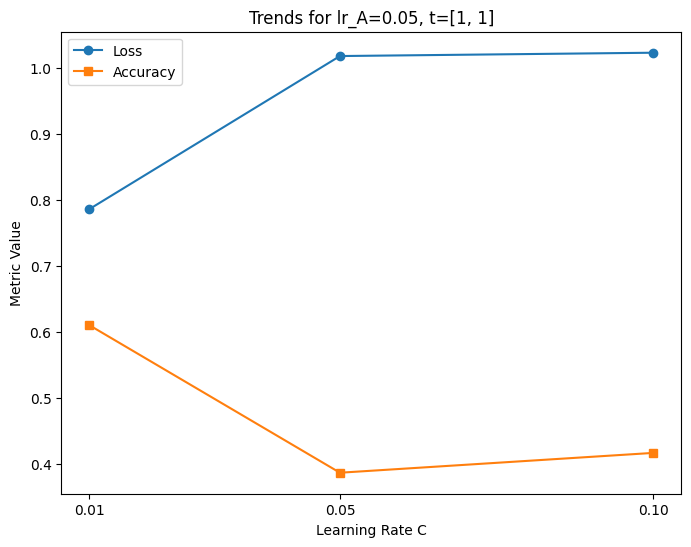

In [109]:
# Example: Plot loss vs lr_C for a fixed lr_A and t
lr_A_fixed = 0.05
t_fixed = [1, 1]

filtered_df = df[(df['lr_A'] == lr_A_fixed) & (df['t'].apply(lambda x: x == t_fixed))]

plt.figure(figsize=(8, 6))
plt.plot(filtered_df['lr_C'], filtered_df['loss'], marker='o', label="Loss")
plt.plot(filtered_df['lr_C'], filtered_df['accuracy'], marker='s', label="Accuracy")
plt.xlabel("Learning Rate C")
plt.ylabel("Metric Value")
plt.xticks(learning_rate_C)
plt.title(f"Trends for lr_A={lr_A_fixed}, t={t_fixed}")
plt.legend()
plt.show()

#### Run

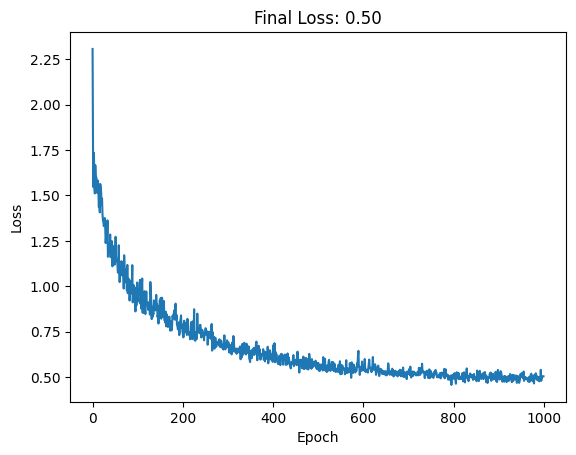

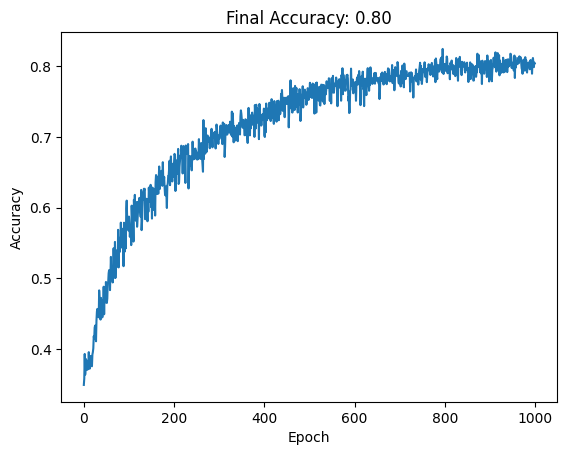

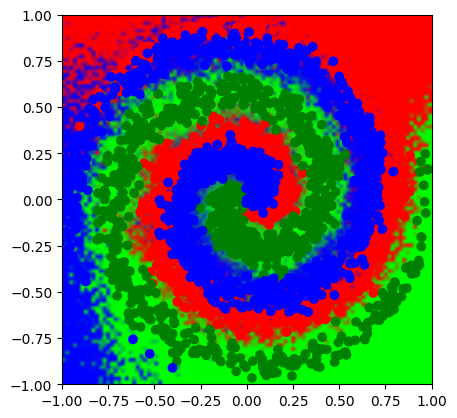

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = spiral_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)


rpu = TikiTakaEcRamPreset()
rpu.device.fast_lr = 0.0128
t = [1, 1]
rpu.forward.out_noise = 0.04

model = Analog_Network_spiral(rpu_config=rpu, t=t).to(device)
optimizer = AnalogSGD(model.parameters(), lr=0.0128)

loss_fn = nn.CrossEntropyLoss()

#loss, accuracy, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 1000, batch_size=128)
loss, accuracy = training_run(X, y, model, optimizer, loss_fn, 1000, batch_size=128)

num_points = 100
plot_prediction_performance(model, X, y, num_points, device)

#plot_evolution(w_C, w_A, window_size=10000)

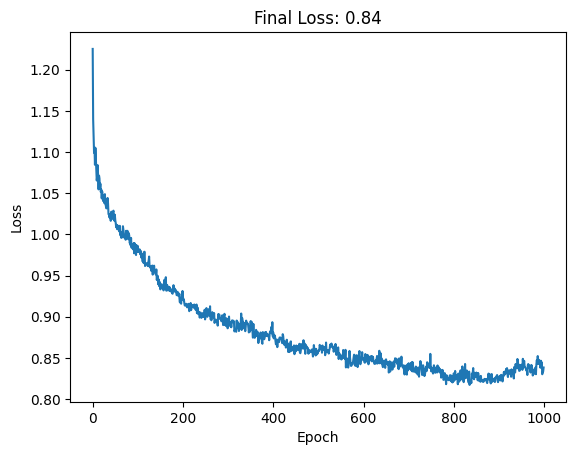

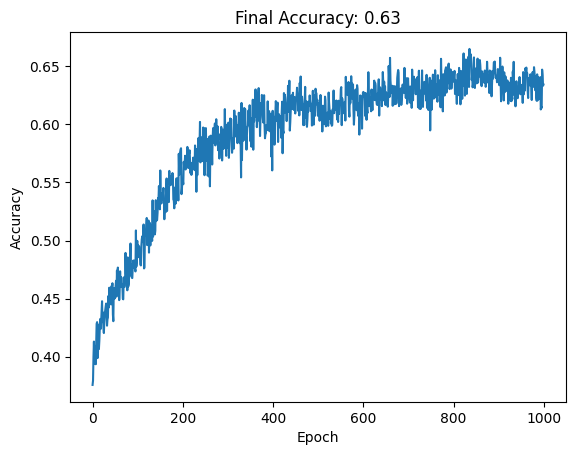

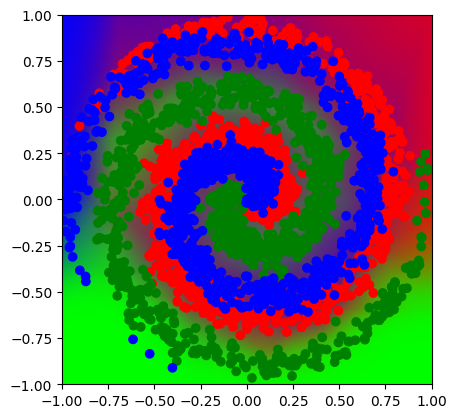

In [58]:
from aihwkit.simulator.presets import EcRamPreset

class Analog_Network_spiral(nn.Module):
    
    def __init__(self, rpu_config=TikiTakaEcRamPreset(), t=[5, 1], device='cpu'):
        super(Analog_Network_spiral, self).__init__()
        self.l1 = AnalogLinear(2, 64, bias=True, rpu_config=rpu_config).to(device)
        self.l2 = AnalogLinear(64, 3, bias=True, rpu_config=rpu_config).to(device)

        # initialize weights using xavier
        self.l1.set_weights(weight = torch.nn.init.xavier_normal_(self.l1.get_weights()[0]), bias = torch.zeros_like(self.l1.get_weights()[1]))
        self.l2.set_weights(weight = torch.nn.init.xavier_normal_(self.l2.get_weights()[0]), bias = torch.zeros_like(self.l2.get_weights()[1])) #torch.randn_like(self.l2.get_weights()[0]) * 0.05

        
    def forward(self, x):
        if self.training:
            x = torch.relu(self.l1(x))
            x = self.l2(x)
            return x * 25
        else:
            self.l1_n = nn.Linear(2, 64, bias=True).to(x.device)
            self.l1_n.weight.data = self.l1.get_weights()[0]
            self.l1_n.bias.data = self.l1.get_weights()[1]
            self.l2_n = nn.Linear(64, 3, bias=True).to(x.device)
            self.l2_n.weight.data = self.l2.get_weights()[0]
            self.l2_n.bias.data = self.l2.get_weights()[1]

            x = torch.relu(self.l1_n(x))
            x = self.l2_n(x)
            return x * 25

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = spiral_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)


rpu = EcRamPreset()
rpu.forward.out_noise = 0.04
rpu.forward.is_perfect = True

model = Analog_Network_spiral(rpu_config=rpu, t=t).to(device)
optimizer = AnalogSGD(model.parameters(), lr=0.005)

loss_fn = nn.CrossEntropyLoss()
loss, accuracy = training_run(X, y, model, optimizer, loss_fn, 1000, batch_size=64)

num_points = 100
plot_prediction_performance(model, X, y, num_points, device)

In [59]:
results.append(model.l1.get_weights()[0].numpy().tolist())

In [60]:
len(results)

5

In [61]:
# save results to a csv file
import csv

with open('SHD_script/training_weight_distribution_sgd_analog.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(results)

In [181]:
# grid search for hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
batch_size = 32
X_np, y_np = spiral_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

noise = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1]
results = []

for n in noise:
    l = []
    a = []
    for _ in range(3):
        rpu = TikiTakaEcRamPreset()
        rpu.device.fast_lr = 0.007
        t = [5, 1]
        rpu.forward.out_noise = n
        model = Analog_Network_spiral(rpu_config=rpu, t=t, device=device)
        optimizer = AnalogSGD(model.parameters(), lr=0.007)
        loss, accuracy, _, _ = training_run(X, y, model, optimizer, nn.CrossEntropyLoss(), 1000, batch_size=batch_size)
        loss = np.mean(loss[-50:])
        accuracy = np.mean(accuracy[-50:])
        l.append(loss)
        a.append(accuracy)
    print(f'Loss: {loss:.2f}, accuracy: {accuracy:.2f} for params: noise: {n}')
    results.append({
        'noise': n,
        'loss': np.max(l),
        'accuracy': np.max(a),
    })


Loss: 0.44, accuracy: 0.82 for params: noise: 0.0
Loss: 0.40, accuracy: 0.85 for params: noise: 0.02
Loss: 1.41, accuracy: 0.65 for params: noise: 0.04
Loss: 0.57, accuracy: 0.78 for params: noise: 0.06
Loss: 1.31, accuracy: 0.65 for params: noise: 0.08
Loss: 1.03, accuracy: 0.66 for params: noise: 0.1


In [183]:
results[2]['accuracy']

0.7574224290780139

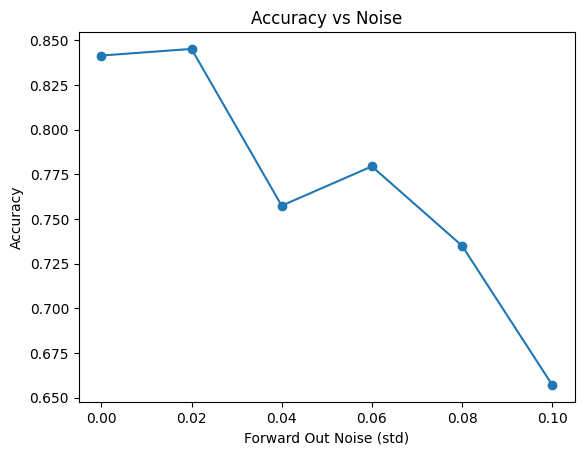

In [192]:
# plot the accuracy for each noise level
plt.plot([r['noise'] for r in results], [r['accuracy'] for r in results], marker='o')
plt.xlabel('Forward Out Noise (std)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Noise')
plt.show()

### Vertical_data

In [27]:
class Analog_Network_vertical(nn.Module):
    def __init__(self, rpu_config=TikiTakaEcRamPreset(), t=[5,1], device='cpu'):
        super(Analog_Network_vertical, self).__init__()
        rpu_config.mapping.digital_bias = False
        rpu_config.device.transfer_every = t[0]
        self.l1 = AnalogLinear(2, 16, bias=True, rpu_config=rpu_config).to(device)
        rpu_config.device.transfer_every = t[1]
        self.l2 = AnalogLinear(16, 3, bias=True, rpu_config=rpu_config).to(device)
        
    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = self.l2(x)
        return x    

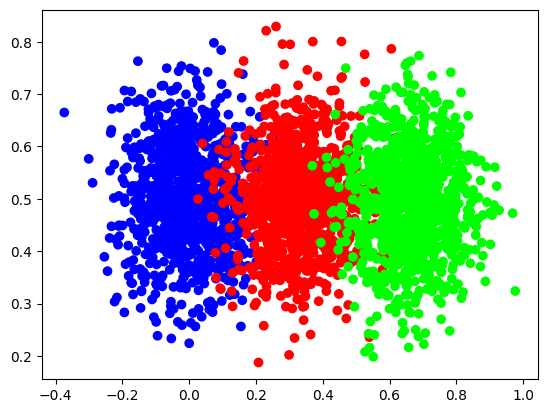

In [28]:
X_np, y_np = vertical_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.int32)

# plot the spiral dataset
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='brg')

In [29]:
# grid search for hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = vertical_data(samples=100, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

# grid search
learning_rate_C = [1e-3, 1e-2, 1e-1]
learning_rate_A = [1e-3, 1e-2, 1e-1]
t = [[1, 1],[5, 1]]

best_loss = float('inf')
best_accuracy = 0

for lr_C in learning_rate_C:
    for lr_A in learning_rate_A:
            for t_ in t:
                rpu = TikiTakaEcRamPreset()
                rpu.device.fast_lr = lr_A
                model = Analog_Network_vertical(rpu_config=rpu, t=t_).to(device)
                optimizer = AnalogSGD(model.parameters(), lr=lr_C)
                loss, accuracy, _, _ = training_run(X, y, model, optimizer, nn.CrossEntropyLoss(), 100)
                print(f'Loss: {loss[-1]:.2f}, accuracy: {accuracy[-1]:.2f} for params: lr_C: {lr_C}, lr_A: {lr_A}, t: {t_}')
                if loss[-1] < best_loss:
                    best_loss = loss[-1]
                    best_accuracy = accuracy[-1]
                    best_params = f'lr_C: {lr_C}, lr_A: {lr_A}, t: {t_}'

print(f'Best loss: {best_loss}, best accuracy: {best_accuracy} for params: {best_params}')

Loss: 0.54, accuracy: 0.90 for params: lr_C: 0.001, lr_A: 0.001, t: [1, 1]
Loss: 0.59, accuracy: 0.84 for params: lr_C: 0.001, lr_A: 0.001, t: [5, 1]
Loss: 0.49, accuracy: 0.87 for params: lr_C: 0.001, lr_A: 0.01, t: [1, 1]
Loss: 0.38, accuracy: 0.93 for params: lr_C: 0.001, lr_A: 0.01, t: [5, 1]
Loss: 0.53, accuracy: 0.79 for params: lr_C: 0.001, lr_A: 0.1, t: [1, 1]
Loss: 0.42, accuracy: 0.91 for params: lr_C: 0.001, lr_A: 0.1, t: [5, 1]
Loss: 0.30, accuracy: 0.91 for params: lr_C: 0.01, lr_A: 0.001, t: [1, 1]
Loss: 0.32, accuracy: 0.89 for params: lr_C: 0.01, lr_A: 0.001, t: [5, 1]
Loss: 0.31, accuracy: 0.90 for params: lr_C: 0.01, lr_A: 0.01, t: [1, 1]
Loss: 0.29, accuracy: 0.91 for params: lr_C: 0.01, lr_A: 0.01, t: [5, 1]
Loss: 0.44, accuracy: 0.85 for params: lr_C: 0.01, lr_A: 0.1, t: [1, 1]
Loss: 0.27, accuracy: 0.91 for params: lr_C: 0.01, lr_A: 0.1, t: [5, 1]
Loss: 0.36, accuracy: 0.89 for params: lr_C: 0.1, lr_A: 0.001, t: [1, 1]
Loss: 0.30, accuracy: 0.90 for params: lr_C: 

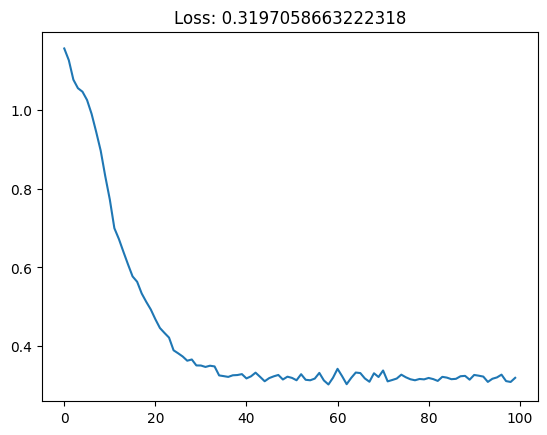

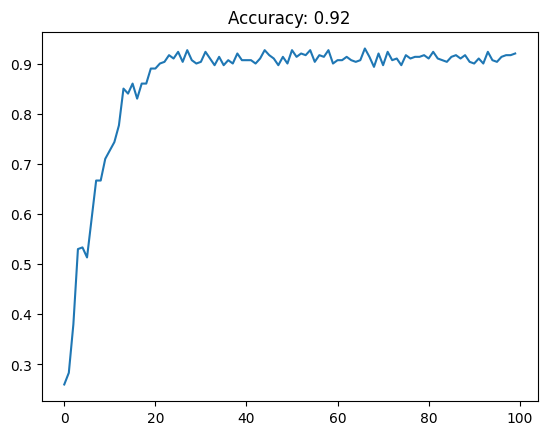

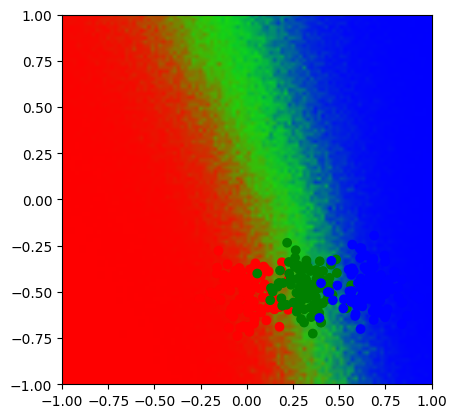

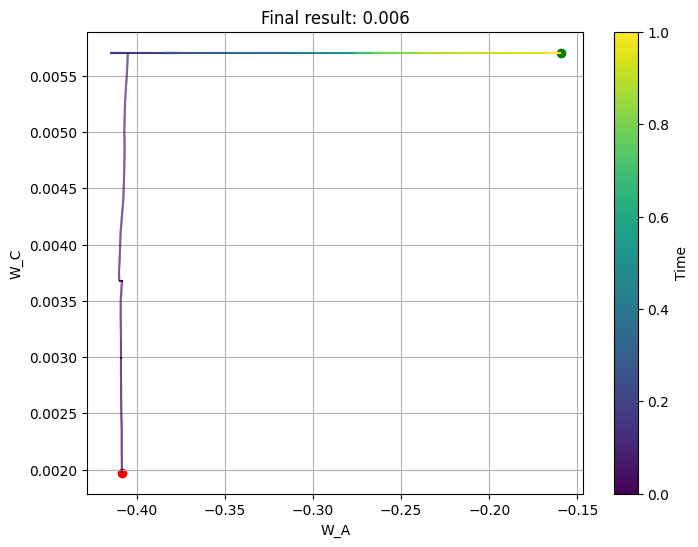

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = vertical_data(samples=100, classes=3)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)

rpu = TikiTakaEcRamPreset()
rpu.device.fast_lr = 0.01
t = [5, 1]
model = Analog_Network_vertical(rpu_config=rpu, t=t).to(device)
optimizer = AnalogSGD(model.parameters(), lr=0.01)

loss_fn = nn.CrossEntropyLoss()

loss, accuracy, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 100, batch_size=1)

plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

plt.plot(accuracy)
plt.title(f'Accuracy: {accuracy[-1]}')
plt.show()

num_points = 100
plot_prediction_performance(model, X, y, num_points, device)
plot_evolution(w_A, w_C, window_size=1000)

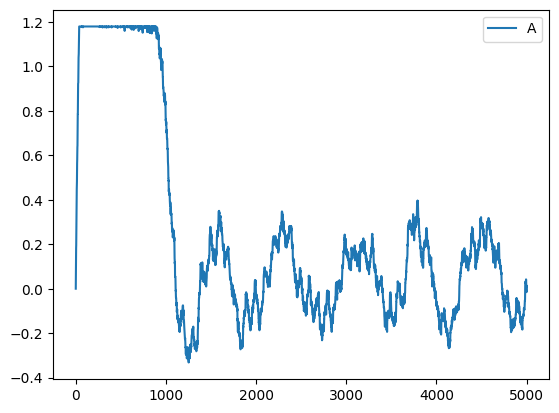

In [30]:
plt.plot(w_A, label='A')
#plt.plot(w_C, label='C')
plt.legend()

### Synthetic data -> regression

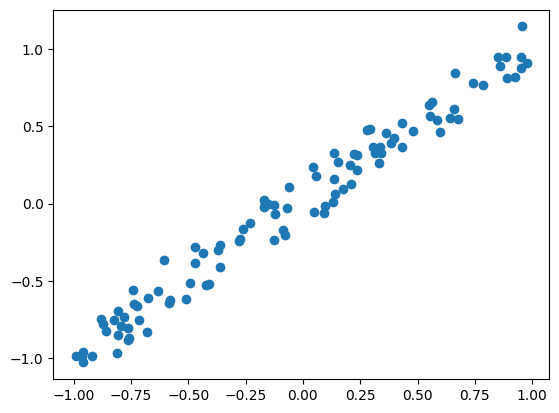

In [37]:
# generate a 100 point dataset for a linear regression problem with 1 feature
def generate_linear_regression_data(num_points=100):
    X = np.random.uniform(-1, 1, (num_points, 1))
    y = 1 * X + np.random.normal(0, 0.1, (num_points, 1))
    return X, y

# plot the data
X, y = generate_linear_regression_data(100)
plt.scatter(X, y)

In [39]:
class Analog_Network_linear(nn.Module):
    def __init__(self, rpu_config=TikiTakaEcRamPreset(), t=[5], device='cpu'):
        super(Analog_Network_linear, self).__init__()
        rpu_config.device.transfer_every = t[0]
        self.l1 = AnalogLinear(1, 1, bias=False, rpu_config=rpu_config).to(device)

    def forward(self, x):
        x = self.l1(x)
        return x

In [23]:
# grid search for hyperparameters
device = 'cpu'
X_np, y_np = generate_linear_regression_data(100)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.float32).to(device)

# grid search
learning_rate_C = [5e-4, 1e-3, 5e-3]
learning_rate_A = [1e-1, 5e-1, 1]
t = [[5], [10], [20]]

best_loss = float('inf')

for lr_C in learning_rate_C:
    for lr_A in learning_rate_A:
            for t_ in t:
                rpu = TikiTakaEcRamPreset()
                rpu.device.fast_lr = lr_A
                model = Analog_Network_linear(rpu_config=rpu, t=t_).to(device)
                optimizer = AnalogSGD(model.parameters(), lr=lr_C)
                loss, _, _, _ = training_run(X, y, model, optimizer, nn.MSELoss(), 50)
                print(f'Loss: {loss[-1]:.2f} for params: lr_C: {lr_C}, lr_A: {lr_A}, t: {t_}')
                if loss[-1] < best_loss:
                    best_loss = loss[-1]
                    best_params = f'lr_C: {lr_C}, lr_A: {lr_A}, t: {t_}'

print(f'Best loss: {best_loss} for params: {best_params}')

Loss: 0.40 for params: lr_C: 0.0005, lr_A: 0.1, t: [5]
Loss: 0.48 for params: lr_C: 0.0005, lr_A: 0.1, t: [10]
Loss: 0.36 for params: lr_C: 0.0005, lr_A: 0.1, t: [20]
Loss: 0.06 for params: lr_C: 0.0005, lr_A: 0.5, t: [5]
Loss: 0.03 for params: lr_C: 0.0005, lr_A: 0.5, t: [10]
Loss: 0.43 for params: lr_C: 0.0005, lr_A: 0.5, t: [20]
Loss: 0.34 for params: lr_C: 0.0005, lr_A: 1, t: [5]
Loss: 0.67 for params: lr_C: 0.0005, lr_A: 1, t: [10]
Loss: 0.26 for params: lr_C: 0.0005, lr_A: 1, t: [20]
Loss: 0.01 for params: lr_C: 0.001, lr_A: 0.1, t: [5]
Loss: 0.05 for params: lr_C: 0.001, lr_A: 0.1, t: [10]
Loss: 0.25 for params: lr_C: 0.001, lr_A: 0.1, t: [20]
Loss: 0.01 for params: lr_C: 0.001, lr_A: 0.5, t: [5]
Loss: 0.33 for params: lr_C: 0.001, lr_A: 0.5, t: [10]
Loss: 0.02 for params: lr_C: 0.001, lr_A: 0.5, t: [20]
Loss: 0.02 for params: lr_C: 0.001, lr_A: 1, t: [5]
Loss: 0.18 for params: lr_C: 0.001, lr_A: 1, t: [10]
Loss: 0.01 for params: lr_C: 0.001, lr_A: 1, t: [20]
Loss: 0.01 for para

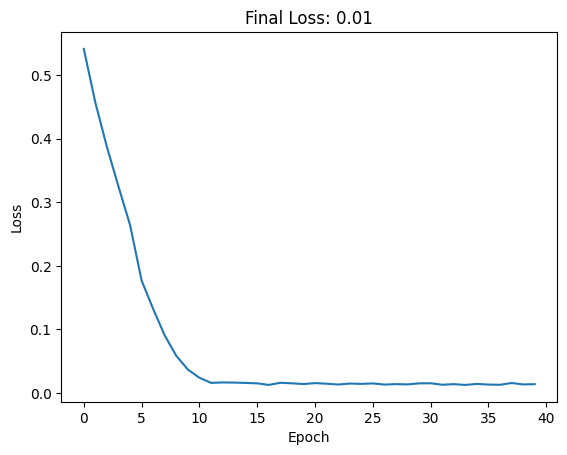

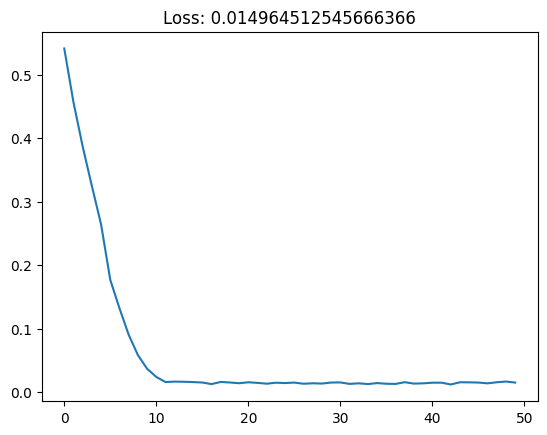

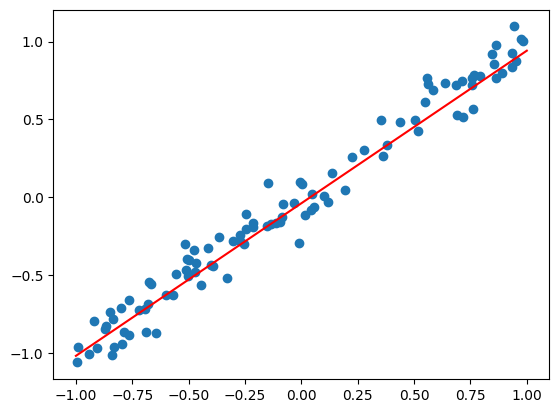

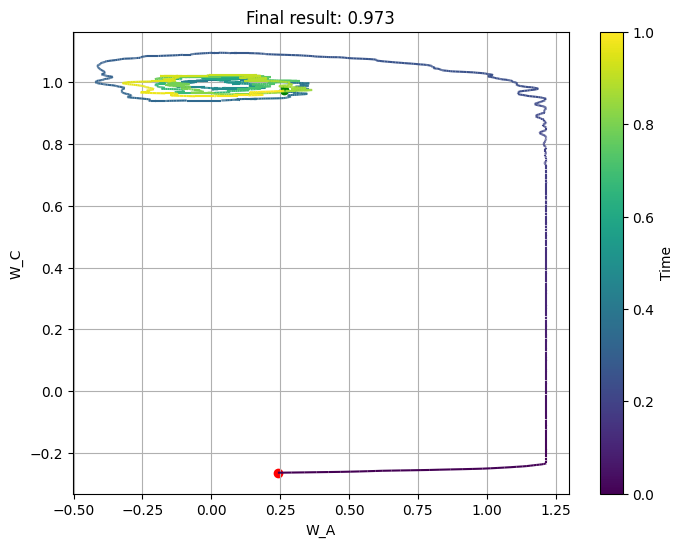

In [42]:
device = 'cpu'
X_np, y_np = generate_linear_regression_data(100)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.float32).to(device)

rpu = TikiTakaEcRamPreset()
rpu.device.fast_lr = 0.1
t = [5]
model = Analog_Network_linear(rpu_config=rpu, t=t).to(device)
optimizer = AnalogSGD(model.parameters(), lr=5e-3)

loss_fn = nn.MSELoss()

loss, _, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 50, batch_size=1)


plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

# plot the linear regression line over the data
X_line = torch.tensor([[-1], [1]], dtype=torch.float32).to(device)
output = model(X_line)
y_line = output.detach().cpu().numpy()
plt.scatter(X_np, y_np)
plt.plot([-1, 1], y_line, c='r')
plt.show()

plot_evolution(w_C, w_A, window_size=10)

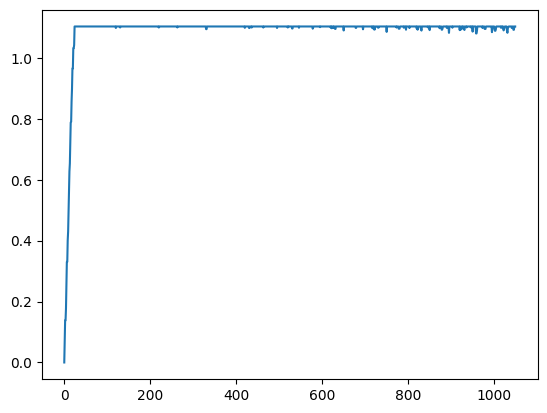

In [41]:
# plot the volution of W_a
plt.plot(w_A[:1050])

## Extra experiments

In [9]:
class Analog_Network_linear(nn.Module):
    def __init__(self, rpu_config=TikiTakaEcRamPreset(), t=[5], device='cpu'):
        super(Analog_Network_linear, self).__init__()
        rpu_config.device.transfer_every = t[0]
        self.l1 = AnalogLinear(1, 1, bias=False, rpu_config=rpu_config).to(device)

    def forward(self, x):
        x = self.l1(x)
        return x

In [ ]:
model.l1.named_analog_tiles

<bound method AnalogLayerBase.named_analog_tiles of AnalogLinear(
  in_features=1, out_features=1, bias=True, TikiTakaEcRamPreset
  (analog_module): AnalogTile(RPUPulsed<float>[Transfer(2): LinearStep -> LinearStep](1,1))
)>

In [85]:
from aihwkit.simulator.configs import NoiseManagementType

device = 'cpu'
rpu = TikiTakaEcRamPreset()
rpu.device.fast_lr = 0.1
t = [5]
rpu.forward.inp_noise = 0.0
rpu.forward.out_noise = 0.1
rpu.forward.noise_management = NoiseManagementType.NONE
model = Analog_Network_linear(rpu_config=rpu, t=t).to(device)
rpu.forward.inp_noise

0.0

In [82]:
rpu.get_default_tile_module_class()

aihwkit.simulator.tiles.analog.AnalogTile

In [ ]:
input = torch.tensor(10).view(1, 1)
model.l1.set_weights(weight = torch.tensor([[0.5]]))

l1 =  model.l1.get_weights()[0] @ input
print('Real output:', l1)

results = []
for i in range(10000):
    results.append(model(input))
print('Mean: ', torch.stack(results).mean(dim=0))
print('Std: ', torch.stack(results).std(dim=0))
print('Signal to noise ratio: ', torch.stack(results).mean(dim=0) / torch.stack(results).std(dim=0))

Real output: tensor([[0.2500]])
Mean:  tensor([[0.2450]], grad_fn=<MeanBackward1>)
Std:  tensor([[0.1029]], grad_fn=<StdBackward0>)
Signal to noise ratio:  tensor([[2.3816]], grad_fn=<DivBackward0>)


In [69]:
model.l1.set_weights(weight = torch.tensor([[0.5]]))
input = torch.linspace(-1, 1, 100).view(-1, 1, 1)
target_output = []
std = []

for i in input: 
    l1 =  model.l1.get_weights()[0] @ i
    target_output.append(l1.item())
    results = []
    for _ in range(1000):
        results.append(model(i))
    std.append(torch.stack(results).std(dim=0).detach().numpy()[0])

Text(0, 0.5, 'Std')

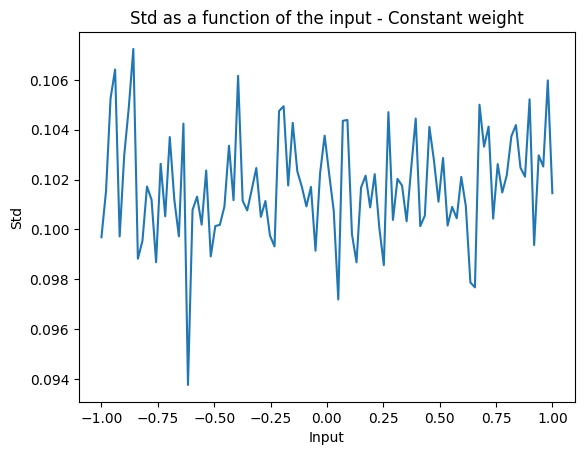

In [70]:
# plot std as a function of the input
plt.plot(input.view(-1), std, label='Std')
plt.title('Std as a function of the input - Constant weight')
plt.xlabel('Input')
plt.ylabel('Std')

In [64]:
weights = torch.linspace(-1, 1.2, 100).view(-1)
input = torch.tensor([[1.0]]).view(1, 1)
target_output = []
std = []

for w in weights: 
    model.l1.set_weights(weight = w)
    l1 =  model.l1.get_weights()[0] @ input
    target_output.append(l1.item())
    results = []
    for _ in range(2000):
        results.append(model(input))
    std.append(torch.stack(results).std(dim=0).detach().numpy()[0])

Text(0, 0.5, 'Std')

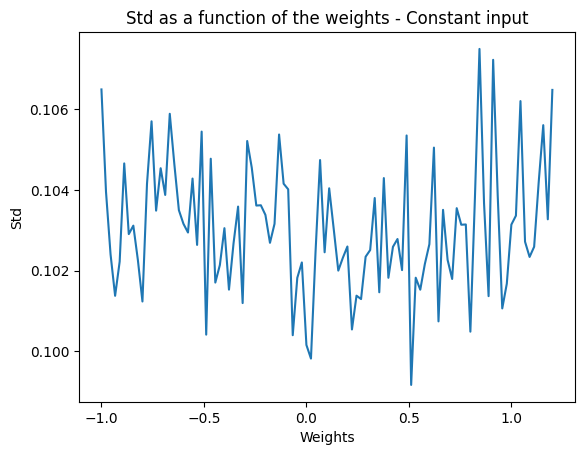

In [65]:
# plot std as a function of the weights
plt.plot(weights, std, label='Std')
plt.title('Std as a function of the weights - Constant input')
plt.xlabel('Weights')
plt.ylabel('Std')